<a href="https://colab.research.google.com/github/linyuehzzz/census_privacy/blob/main/franklin_data_buildings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


####**Read data**

In [ ]:
!pip install geopandas

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import geopandas as gpd

filename_building = 'franklin/buildings/franklin_buildings.json'
data = gpd.read_file(filename_building)
data

/content/gdrive/My Drive/Colab Notebooks/census_privacy


,OBJECTID,Building_ID,GEOID10,PUMA,Shape_Length,Shape_Area,land_value,near_school_dist,accessibility,Area,geometry
0,1,1,390490073943030,3904101,0.000779,2.779850e-08,11.371515,1.469520,0,263.381747,"POLYGON ((-82.76948 40.03471, -82.76953 40.034..."
1,2,2,390490072031031,3904101,0.000336,7.011000e-09,11.246373,0.792078,0,66.362896,"POLYGON ((-82.77188 40.10144, -82.77197 40.101..."
2,3,3,390490072031031,3904101,0.000267,4.216500e-09,12.244342,0.433578,0,39.905402,"POLYGON ((-82.77246 40.11178, -82.77251 40.111..."
3,4,4,390490073943030,3904101,0.000690,2.311800e-08,11.500648,1.250005,0,219.030016,"POLYGON ((-82.77279 40.03673, -82.77304 40.036..."
4,5,5,390490073962108,3904101,0.000548,1.462400e-08,11.920041,1.812932,8,138.618666,"POLYGON ((-82.77294 40.00425, -82.77300 40.004..."
...,...,...,...,...,...,...,...,...,...,...,...
390124,390125,390125,390490080003007,3904111,0.000968,3.941550e-08,11.238415,2.790384,0,373.625217,"POLYGON ((-83.24400 40.02583, -83.24411 40.025..."
390125,390126,390126,390490080001007,3904111,0.000887,4.289700e-08,10.416450,3.159957,2,406.954095,"POLYGON ((-83.24511 39.97005, -83.24524 39.970..."
390126,390127,390127,390490098001032,3904111,0.000584,2.044200e-08,10.697505,3.202852,0,194.178110,"POLYGON ((-83.24573 39.88030, -83.24582 39.880..."
390127,390128,390128,390490098001032,3904111,0.000596,2.093900e-08,11.497328,3.362483,0,198.879741,"POLYGON ((-83.24714 39.88745, -83.24725 39.887..."


#### **Land value**

count    390129.000000
mean         13.075756
std           0.676666
min           8.796474
25%          12.844518
50%          13.247377
75%          13.534178
max          14.332868
Name: land_value, dtype: float64
-1.9055655492562087 4.7754424748635005


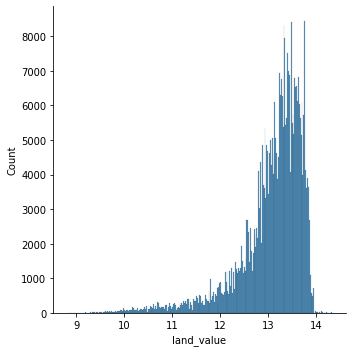

In [ ]:
import seaborn as sns
from scipy import stats

sns.displot(data["land_value"])
print(data["land_value"].describe())
print(stats.skew(data["land_value"]), stats.kurtosis(data["land_value"]))

(13.075756015285606,
 0.6766653657187465,
 -14.440645522967111,
 13.840248871993493,
 1.0209435003066822)

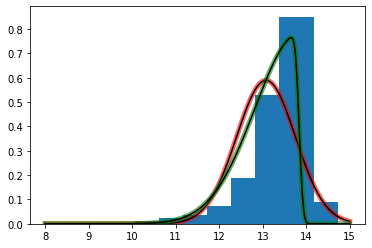

In [ ]:
import numpy as np
from scipy.stats import norm, skewnorm
import matplotlib.pyplot as plt

y, x = np.histogram(data["land_value"], density=True)
xx = np.linspace(8, 15, 1000)
# normal distribution
loc1, scale1 = norm.fit(data["land_value"])  
pdf_norm = norm.pdf(xx, loc1, scale1)  
plt.plot(xx, pdf_norm, 'r-', lw=5, alpha=0.6, label='norm pdf')
plt.plot(xx, pdf_norm, 'k-')

# skew norm
a, loc2, scale2 = skewnorm.fit(data["land_value"])  
pdf_skewnorm = skewnorm.pdf(xx, a, loc2, scale2)  
plt.plot(xx, pdf_skewnorm, 'g-', lw=5, alpha=0.6, label='skewnorm pdf')
plt.plot(xx, pdf_skewnorm, 'k-')

plt.bar(x[1:], y, label='Data')
loc1, scale1, a, loc2, scale2

Fit a normal distribution to the data.

(12.611830042167421,
 0.6747830481369294,
 13.388746964841724,
 0.08153794915608908,
 13.689717692373627,
 0.09922617012634513)

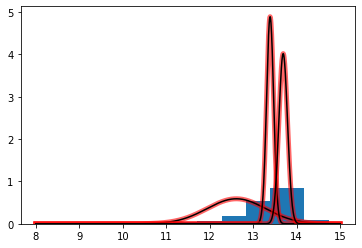

In [ ]:
import numpy as np
from scipy.stats import norm, skewnorm
import matplotlib.pyplot as plt

y, x = np.histogram(data["land_value"], density=True)
xx = np.linspace(8, 15, 1000)
# low income
data1 = data[data["land_value"] < np.quantile(data["land_value"], .50)]
loc1, scale1 = norm.fit(data1["land_value"])  
pdf_norm1 = norm.pdf(xx, loc1, scale1)  

# median income
data2 = data[(data["land_value"] >= np.quantile(data["land_value"], .50)) 
& (data["land_value"] <= np.quantile(data["land_value"], .75))]
loc2, scale2 = norm.fit(data2["land_value"])  
pdf_norm2 = norm.pdf(xx, loc2, scale2)  

# high income
data3 = data[data["land_value"] > np.quantile(data["land_value"], .75)]
loc3, scale3 = norm.fit(data3["land_value"])  
pdf_norm3 = norm.pdf(xx, loc3, scale3)  

plt.plot(xx, pdf_norm1, 'r-', lw=5, alpha=0.6, label='norm pdf')
plt.plot(xx, pdf_norm1, 'k-')
plt.plot(xx, pdf_norm2, 'r-', lw=5, alpha=0.6, label='norm pdf')
plt.plot(xx, pdf_norm2, 'k-')
plt.plot(xx, pdf_norm3, 'r-', lw=5, alpha=0.6, label='norm pdf')
plt.plot(xx, pdf_norm3, 'k-')
plt.bar(x[1:], y, label='Data')
loc1, scale1, loc2, scale2, loc3, scale3

Calculate weights of land value for low/median/high income households.

In [ ]:
from scipy.stats import norm

def normalize_df(data):
    return (data - data.min())/(data.max() - data.min())
# loc1 = 12.6118
# scale1 = 0.6748
# loc2 = 13.3887
# scale2 = 0.0815
# loc3 = 13.6897
# scale3 = 0.0992

data["land_value_low"] = normalize_df(norm.pdf(data["land_value"], loc1, scale1))
data["land_value_med"] = normalize_df(norm.pdf(data["land_value"], loc2, scale2))
data["land_value_high"] = normalize_df(norm.pdf(data["land_value"], loc3, scale3))
data.head()

,OBJECTID,Building_ID,GEOID10,PUMA,Shape_Length,Shape_Area,land_value,near_school_dist,accessibility,Area,geometry,land_value_low,land_value_med,land_value_high
0,1,1,390490073943030,3904101,0.000779,2.779850e-08,11.371515,1.469520,0,263.381747,"POLYGON ((-82.76948 40.03471, -82.76953 40.034...",0.041935,0.053736,1.365172e-30
1,2,2,390490072031031,3904101,0.000336,7.011000e-09,11.246373,0.792078,0,66.362896,"POLYGON ((-82.77188 40.10144, -82.77197 40.101...",0.025874,0.039652,3.794018e-34
2,3,3,390490072031031,3904101,0.000267,4.216500e-09,12.244342,0.433578,0,39.905402,"POLYGON ((-82.77246 40.11178, -82.77251 40.111...",0.470084,0.294711,2.378456e-11
3,4,4,390490073943030,3904101,0.000690,2.311800e-08,11.500648,1.250005,0,219.030016,"POLYGON ((-82.77279 40.03673, -82.77304 40.036...",0.066589,0.072382,3.935883e-27
4,5,5,390490073962108,3904101,0.000548,1.462400e-08,11.920041,1.812932,8,138.618666,"POLYGON ((-82.77294 40.00425, -82.77300 40.004...",0.232572,0.170544,2.306679e-17


####**School**

In [ ]:
def normalize_neg_df(data):
    return (data.max() - data)/(data.max() - data.min())

data["near_school_dist_w"] = normalize_neg_df(data["near_school_dist"])
data["near_school_dist_wo"] = 1
data.head()

,OBJECTID,Building_ID,GEOID10,PUMA,Shape_Length,Shape_Area,land_value,near_school_dist,accessibility,Area,geometry,land_value_low,land_value_med,land_value_high,near_school_dist_w,near_school_dist_wo
0,1,1,390490073943030,3904101,0.000779,2.779850e-08,11.371515,1.469520,0,263.381747,"POLYGON ((-82.76948 40.03471, -82.76953 40.034...",0.041935,0.053736,1.365172e-30,0.655379,1
1,2,2,390490072031031,3904101,0.000336,7.011000e-09,11.246373,0.792078,0,66.362896,"POLYGON ((-82.77188 40.10144, -82.77197 40.101...",0.025874,0.039652,3.794018e-34,0.814248,1
2,3,3,390490072031031,3904101,0.000267,4.216500e-09,12.244342,0.433578,0,39.905402,"POLYGON ((-82.77246 40.11178, -82.77251 40.111...",0.470084,0.294711,2.378456e-11,0.898321,1
3,4,4,390490073943030,3904101,0.000690,2.311800e-08,11.500648,1.250005,0,219.030016,"POLYGON ((-82.77279 40.03673, -82.77304 40.036...",0.066589,0.072382,3.935883e-27,0.706858,1
4,5,5,390490073962108,3904101,0.000548,1.462400e-08,11.920041,1.812932,8,138.618666,"POLYGON ((-82.77294 40.00425, -82.77300 40.004...",0.232572,0.170544,2.306679e-17,0.574845,1


####**Accessibility and area**

In [ ]:
def normalize_df(data):
    return (data - data.min())/(data.max() - data.min())

data["accessibility_normed"] = normalize_df(data["accessibility"])
data["area_normed"] = normalize_df(data["Area"])
data.head()

,OBJECTID,Building_ID,GEOID10,PUMA,Shape_Length,Shape_Area,land_value,near_school_dist,accessibility,Area,geometry,land_value_low,land_value_med,land_value_high,near_school_dist_w,near_school_dist_wo,accessibility_normed,area_normed
0,1,1,390490073943030,3904101,0.000779,2.779850e-08,11.371515,1.469520,0,263.381747,"POLYGON ((-82.76948 40.03471, -82.76953 40.034...",0.041935,0.053736,1.365172e-30,0.655379,1,0.00000,0.001184
1,2,2,390490072031031,3904101,0.000336,7.011000e-09,11.246373,0.792078,0,66.362896,"POLYGON ((-82.77188 40.10144, -82.77197 40.101...",0.025874,0.039652,3.794018e-34,0.814248,1,0.00000,0.000298
2,3,3,390490072031031,3904101,0.000267,4.216500e-09,12.244342,0.433578,0,39.905402,"POLYGON ((-82.77246 40.11178, -82.77251 40.111...",0.470084,0.294711,2.378456e-11,0.898321,1,0.00000,0.000179
3,4,4,390490073943030,3904101,0.000690,2.311800e-08,11.500648,1.250005,0,219.030016,"POLYGON ((-82.77279 40.03673, -82.77304 40.036...",0.066589,0.072382,3.935883e-27,0.706858,1,0.00000,0.000984
4,5,5,390490073962108,3904101,0.000548,1.462400e-08,11.920041,1.812932,8,138.618666,"POLYGON ((-82.77294 40.00425, -82.77300 40.004...",0.232572,0.170544,2.306679e-17,0.574845,1,0.01626,0.000623


####**Entropy weight method**
Determine the weight for each indicator.

In [ ]:
import numpy as np

def entropy(data):
    m = len(data)
    p = data / data.sum()
    H = - 1 / np.log(m) * np.sum(p * np.log(p))
    return H

def entropy_weight(H):
    return (1 - H) / (len(H) - np.sum(H))

print(entropy(data["land_value_low"]), entropy(data["land_value_med"]), entropy(data["land_value_high"]), 
      entropy(data["near_school_dist_w"]), entropy(data["near_school_dist_wo"]), entropy(data["accessibility_normed"]), entropy(data["area_normed"]))

# type 1
H1 = np.array([entropy(data["land_value_low"]), entropy(data["near_school_dist_w"]), entropy(data["accessibility_normed"]), entropy(data["area_normed"])])
W1 = entropy_weight(H1)
# type 2
H2 = np.array([entropy(data["land_value_low"]), 1., entropy(data["accessibility_normed"]), entropy(data["area_normed"])])
W2 = entropy_weight(H2)
# type 3
H3 = np.array([entropy(data["land_value_med"]), entropy(data["near_school_dist_w"]), entropy(data["accessibility_normed"]), entropy(data["area_normed"])])
W3 = entropy_weight(H3)
# type 4
H4 = np.array([entropy(data["land_value_med"]), 1., entropy(data["accessibility_normed"]), entropy(data["area_normed"])])
W4 = entropy_weight(H4)
# type 5
H5 = np.array([entropy(data["land_value_high"]), entropy(data["near_school_dist_w"]), entropy(data["accessibility_normed"]), entropy(data["area_normed"])])
W5 = entropy_weight(H5)
# type 6
H6 = np.array([entropy(data["land_value_high"]), 1., entropy(data["accessibility_normed"]), entropy(data["area_normed"])])
W6 = entropy_weight(H6)

[W1, W2, W3, W4, W5, W6]

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.9941769604500225 0.9929933494373502 0.9520538512655088 0.9994825106586395 1.0000000000000002 0.9632795095827045 0.921962861052432


[array([0.04808529, 0.0042733 , 0.30322914, 0.64441227]),
 array([0.04829165, 0.        , 0.30453049, 0.64717786]),
 array([0.05729922, 0.00423194, 0.30029407, 0.63817476]),
 array([0.05754274, 0.        , 0.3015703 , 0.64088696]),
 array([0.2937494 , 0.00317048, 0.22497369, 0.47810644]),
 array([0.29468368, 0.        , 0.22568923, 0.47962709])]

Calculate the score of choosing the building for six types of households:

- Low income households with school age children
- Low income households without school age children
- Median income households with school age children
- Median income households without school age children
- High income households with school age children
- High income households without school age children

In [ ]:
data["score1"] = W1[0] * data["land_value_low"] + W1[1] * data["near_school_dist_w"] + W1[2] * data["accessibility_normed"] + W1[3] * data["area_normed"]
data["score2"] = W2[0] * data["land_value_low"] + W2[1] * 1. + W2[2] * data["accessibility_normed"] + W2[3] * data["area_normed"]
data["score3"] = W3[0] * data["land_value_med"] + W3[1] * data["near_school_dist_w"] + W3[2] * data["accessibility_normed"] + W3[3] * data["area_normed"]
data["score4"] = W4[0] * data["land_value_med"] + W4[1] * 1. + W4[2] * data["accessibility_normed"] + W4[3] * data["area_normed"]
data["score5"] = W5[0] * data["land_value_high"] + W5[1] * data["near_school_dist_w"] + W5[2] * data["accessibility_normed"] + W5[3] * data["area_normed"]
data["score6"] = W6[0] * data["land_value_high"] + W6[1] * 1. + W6[2] * data["accessibility_normed"] + W6[3] * data["area_normed"]
data.head()

,OBJECTID,Building_ID,GEOID10,PUMA,Shape_Length,Shape_Area,land_value,near_school_dist,accessibility,Area,geometry,land_value_low,land_value_med,land_value_high,near_school_dist_w,near_school_dist_wo,accessibility_normed,area_normed,score1,score2,score3,score4,score5,score6
0,1,1,390490073943030,3904101,0.000779,2.779850e-08,11.371515,1.469520,0,263.381747,"POLYGON ((-82.76948 40.03471, -82.76953 40.034...",0.041935,0.053736,1.365172e-30,0.655379,1,0.00000,0.001184,0.005580,0.002791,0.006608,0.003851,0.002644,0.000568
1,2,2,390490072031031,3904101,0.000336,7.011000e-09,11.246373,0.792078,0,66.362896,"POLYGON ((-82.77188 40.10144, -82.77197 40.101...",0.025874,0.039652,3.794018e-34,0.814248,1,0.00000,0.000298,0.004916,0.001442,0.005908,0.002473,0.002724,0.000143
2,3,3,390490072031031,3904101,0.000267,4.216500e-09,12.244342,0.433578,0,39.905402,"POLYGON ((-82.77246 40.11178, -82.77251 40.111...",0.470084,0.294711,2.378456e-11,0.898321,1,0.00000,0.000179,0.026558,0.022817,0.020803,0.017073,0.002934,0.000086
3,4,4,390490073943030,3904101,0.000690,2.311800e-08,11.500648,1.250005,0,219.030016,"POLYGON ((-82.77279 40.03673, -82.77304 40.036...",0.066589,0.072382,3.935883e-27,0.706858,1,0.00000,0.000984,0.006857,0.003853,0.007767,0.004796,0.002712,0.000472
4,5,5,390490073962108,3904101,0.000548,1.462400e-08,11.920041,1.812932,8,138.618666,"POLYGON ((-82.77294 40.00425, -82.77300 40.004...",0.232572,0.170544,2.306679e-17,0.574845,1,0.01626,0.000623,0.018972,0.016586,0.017485,0.015116,0.005778,0.003968


####**Score to probability**

In [ ]:
data["prob1"] = data["prob2"] = data["prob3"] = data["prob4"] = data["prob5"] = data["prob6"] = 0
for GEOID in data["GEOID10"].unique():
    sub_data = data[data["GEOID10"] == GEOID]
    sub_data["prob1"] = sub_data["score1"] / sub_data["score1"].sum()
    sub_data["prob2"] = sub_data["score2"] / sub_data["score2"].sum()
    sub_data["prob3"] = sub_data["score3"] / sub_data["score3"].sum()
    sub_data["prob4"] = sub_data["score4"] / sub_data["score4"].sum()
    sub_data["prob5"] = sub_data["score5"] / sub_data["score5"].sum()
    sub_data["prob6"] = sub_data["score6"] / sub_data["score6"].sum()

    prob = sub_data[["prob1", "prob2", "prob3", "prob4", "prob5", "prob6"]].values.tolist()

    data.loc[(data["GEOID10"] == GEOID), ["prob1", "prob2", "prob3", "prob4", "prob5", "prob6"]] = prob

data.head()

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,OBJECTID,Building_ID,GEOID10,PUMA,Shape_Length,Shape_Area,land_value,near_school_dist,accessibility,Area,geometry,land_value_low,land_value_med,land_value_high,near_school_dist_w,near_school_dist_wo,accessibility_normed,area_normed,score1,score2,score3,score4,score5,score6,prob1,prob2,prob3,prob4,prob5,prob6
0,1,1,390490073943030,3904101,0.000779,2.779850e-08,11.371515,1.469520,0,263.381747,"POLYGON ((-82.76948 40.03471, -82.76953 40.034...",0.041935,0.053736,1.365172e-30,0.655379,1,0.00000,0.001184,0.005580,0.002791,0.006608,0.003851,0.002644,0.000568,0.044962,0.043204,0.048824,0.050354,0.050932,0.074844
1,2,2,390490072031031,3904101,0.000336,7.011000e-09,11.246373,0.792078,0,66.362896,"POLYGON ((-82.77188 40.10144, -82.77197 40.101...",0.025874,0.039652,3.794018e-34,0.814248,1,0.00000,0.000298,0.004916,0.001442,0.005908,0.002473,0.002724,0.000143,0.004931,0.002192,0.006244,0.004050,0.009111,0.003128
2,3,3,390490072031031,3904101,0.000267,4.216500e-09,12.244342,0.433578,0,39.905402,"POLYGON ((-82.77246 40.11178, -82.77251 40.111...",0.470084,0.294711,2.378456e-11,0.898321,1,0.00000,0.000179,0.026558,0.022817,0.020803,0.017073,0.002934,0.000086,0.026642,0.034673,0.021984,0.027963,0.009812,0.001880
3,4,4,390490073943030,3904101,0.000690,2.311800e-08,11.500648,1.250005,0,219.030016,"POLYGON ((-82.77279 40.03673, -82.77304 40.036...",0.066589,0.072382,3.935883e-27,0.706858,1,0.00000,0.000984,0.006857,0.003853,0.007767,0.004796,0.002712,0.000472,0.055253,0.059637,0.057388,0.062714,0.052240,0.062239
4,5,5,390490073962108,3904101,0.000548,1.462400e-08,11.920041,1.812932,8,138.618666,"POLYGON ((-82.77294 40.00425, -82.77300 40.004...",0.232572,0.170544,2.306679e-17,0.574845,1,0.01626,0.000623,0.018972,0.016586,0.017485,0.015116,0.005778,0.003968,0.001207,0.001112,0.001291,0.001187,0.001561,0.001293


####**Assign centroids**

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import geopandas as gpd

filename_buildings0 = 'franklin/buildings/franklin_buildings.json'
data_buildings0 = gpd.read_file(filename_buildings0)

for building in data_buildings["Building_ID"].unique():
    data_buildings.loc[data_buildings["Building_ID"] == building, 
                       "lon"] = data_buildings0[data_buildings0["Building_ID"] == building]["centroid_lon"]
    data_buildings.loc[data_buildings["Building_ID"] == building, 
                       "lat"] = data_buildings0[data_buildings0["Building_ID"] == building]["centroid_lat"]            
data_buildings.head()           

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import geopandas as gpd

filename_building = 'franklin/buildings/franklin_buildingsv1.json'
data.to_file(filename_building, driver='GeoJSON')

/content/gdrive/My Drive/Colab Notebooks/census_privacy
